In [4]:
from __future__ import division

import numpy as np
from numpy import *

import os

import PIL
from PIL import Image
import matplotlib.pyplot as plt

from skimage import data, io, filters

from matplotlib.path import Path
import matplotlib.patches as patches
import pandas as pd

In [21]:
## path to style samples
noise_path = '/home/jefan/full_sketchy_dataset/noise/'
style_sample_path = '/home/jefan/pix2svg/generative/tests/style_test/style_samples'

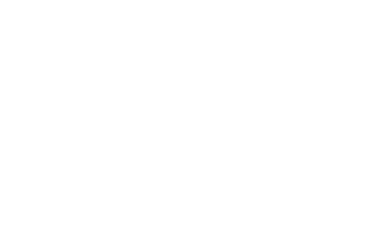

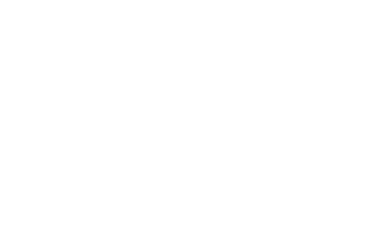

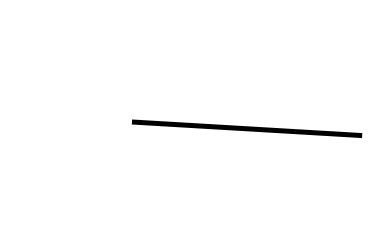

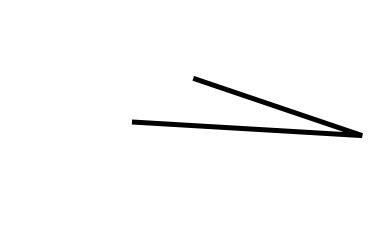

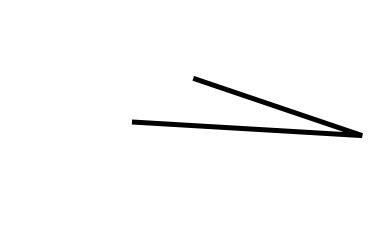

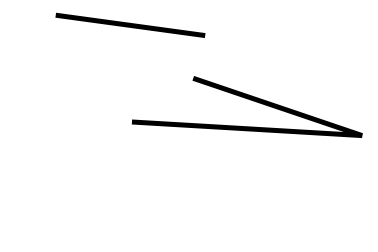

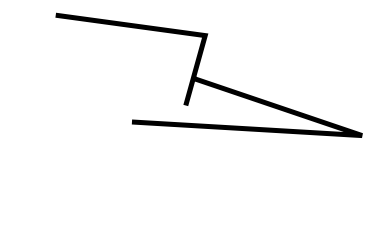

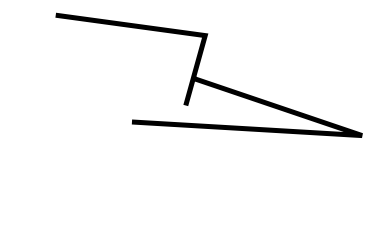

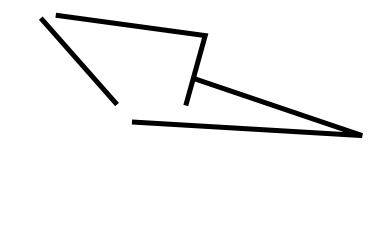

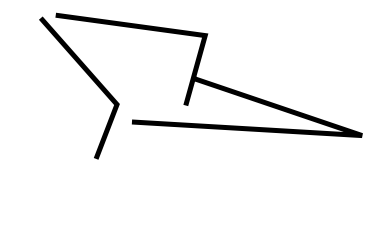

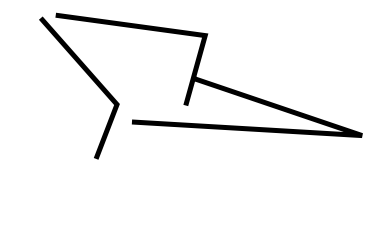

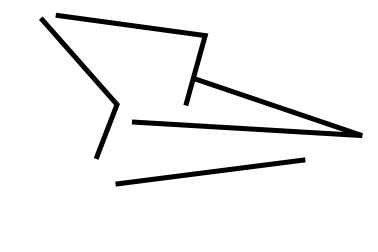

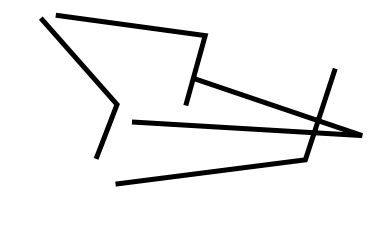

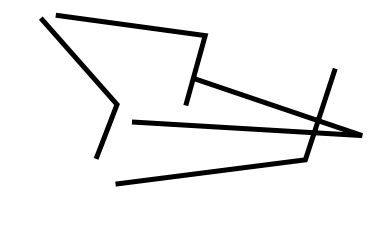

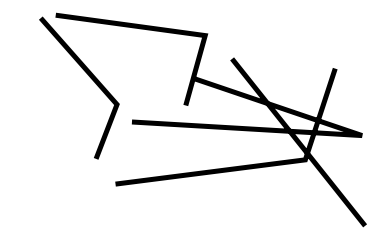

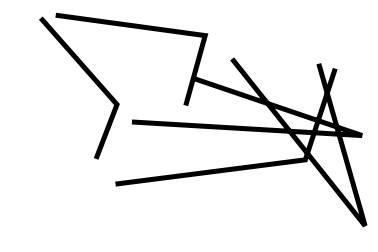

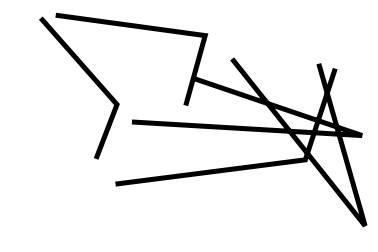

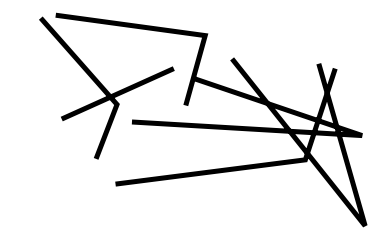

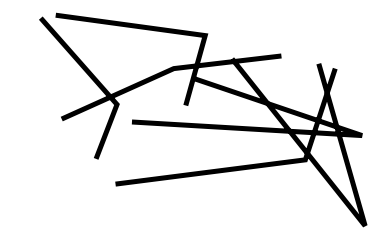

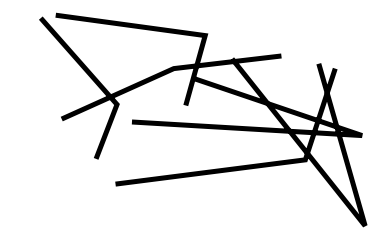

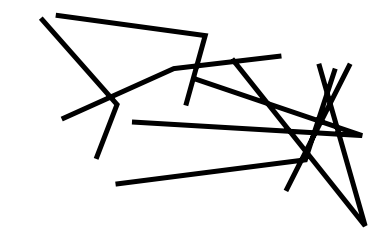

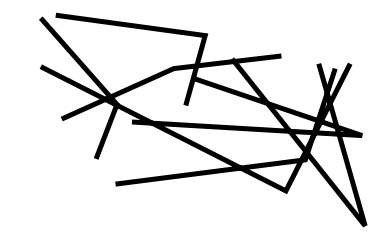

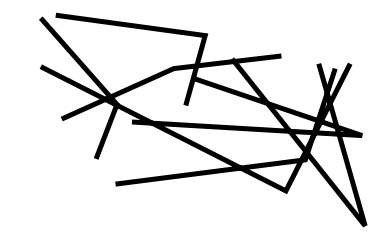

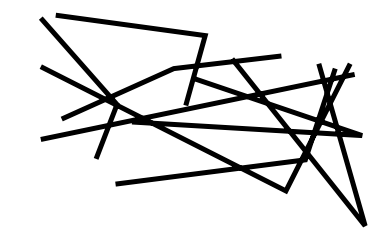

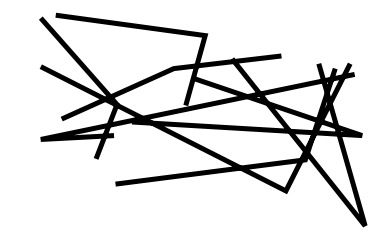

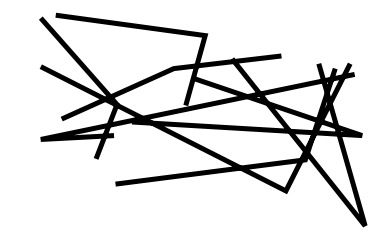

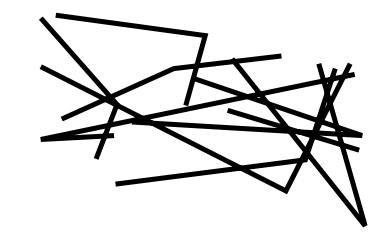

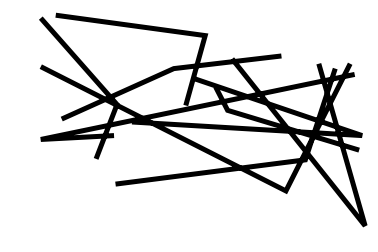

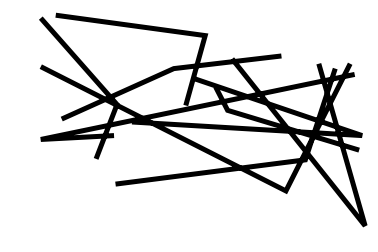

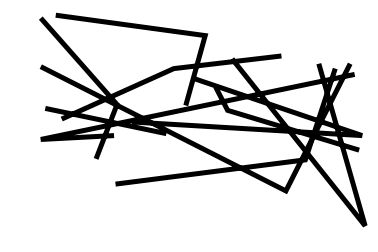

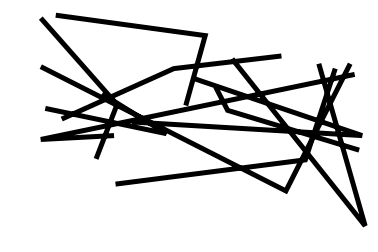

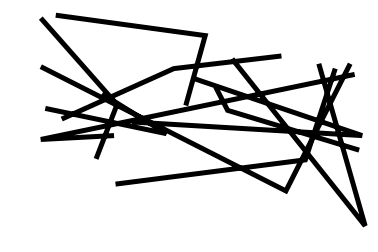

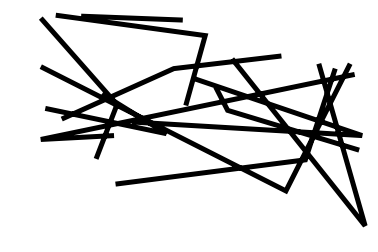

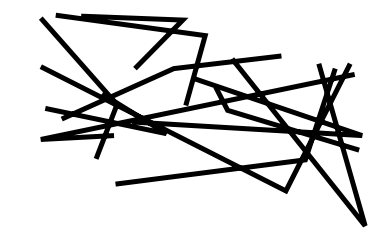

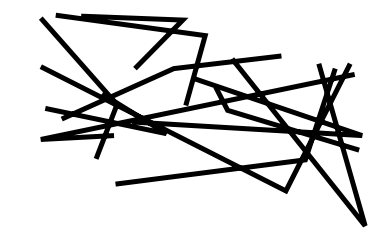

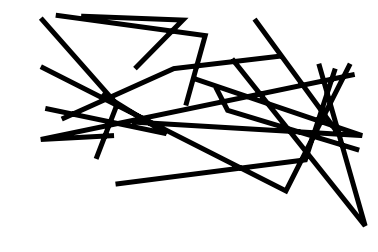

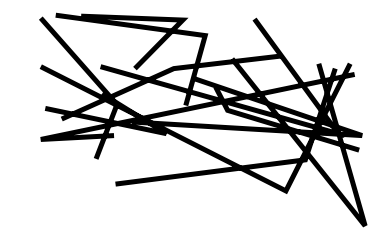

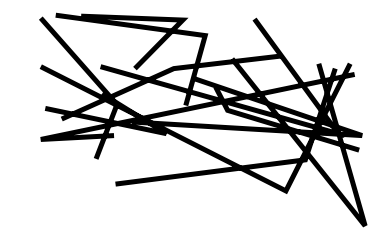

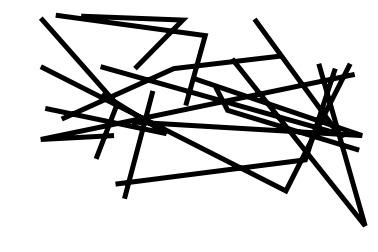

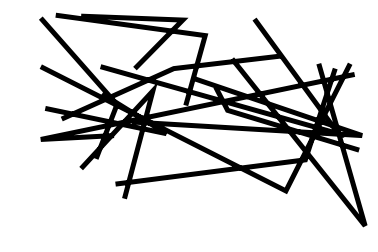

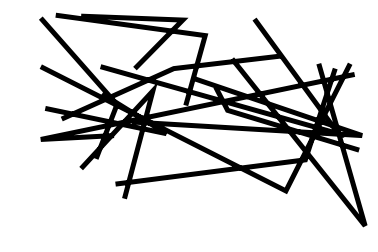

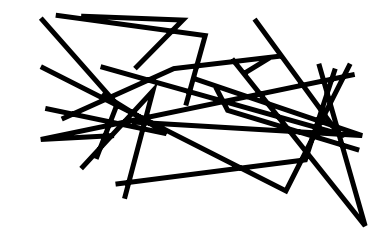

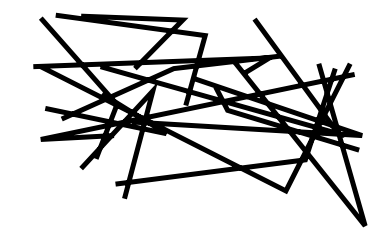

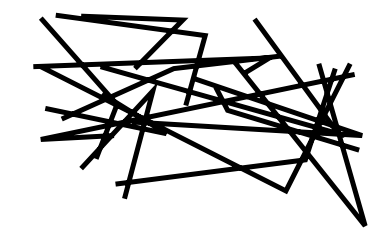

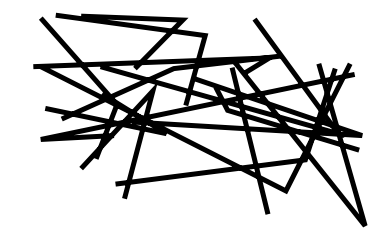

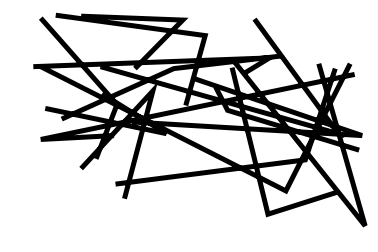

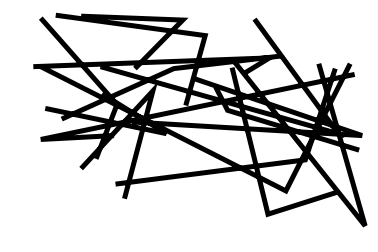

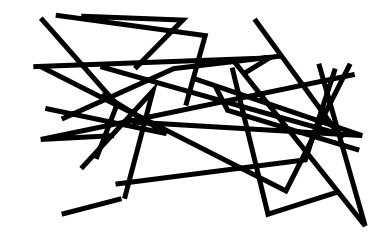

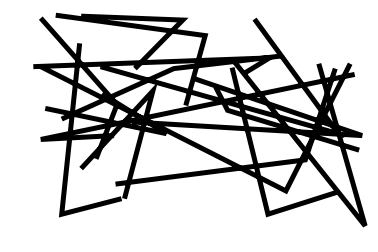

In [254]:
## gen random sketch parameterized by number of strokes
total_points = 50
im_size = 224
x = np.random.choice(arange(im_size),total_points)
y = np.random.choice(arange(im_size),total_points)
for num_points in range(1,total_points):
    _x = x[:num_points]
    _y = y[:num_points]    
    verts = zip(_x,_y)
    codes = [Path.MOVETO]
    for i,v in enumerate(verts):
        if i<len(verts)-1:
            if i%3==0:
                codes.append(Path.MOVETO) 
            else:
                codes.append(Path.LINETO) # keep pen on page
        else:
            if i != len(verts)-1: # final vertex
                codes.append(Path.MOVETO)

    fig = plt.figure()    
    ax = plt.subplot(111)
    ax.axis('off')
    ax.set_xlim(0,224)
    ax.set_ylim(0,224)
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=5)
    ax.add_patch(patch)
    plt.gca().invert_yaxis() # y values increase as you go down in image
    plt.show()

    ### save out as png   
    if not os.path.exists(style_sample_path):
        os.makedirs(style_sample_path)
    filepath = os.path.join(style_sample_path,str(num_points)+'.png')
    fig.savefig(filepath,bbox_inches='tight')
    plt.close()            

In [80]:
verts

[]

In [232]:
"""Neural Style Transfer. This is almost copy-pasta
from Alexis Jacq's PyTorch tutorial:
https://github.com/pytorch/tutorials/blob/master/advanced_source/neural_style_tutorial.py
"""

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import


import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy


# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss


class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)


class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss


def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default,
                               use_cuda=False):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # the new Sequential module network
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses


def get_input_param_optimizer(input_img, init_lr=0.1):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param], lr=init_lr)
    return input_param, optimizer


def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1, use_cuda=False,
                       init_lr=0.1, anneal_freq=100,save_dir='./outputs'):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight, use_cuda=use_cuda)
    input_param, optimizer = get_input_param_optimizer(input_img, init_lr=init_lr)

    def adjust_learning_rate(optimizer, epoch):
        lr = init_lr * (0.1** (epoch // anneal_freq))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        if epoch % anneal_freq == 0:
            print('Learning rate set to {}'.format(lr))

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)
            optimizer.zero_grad()
            #import pdb; pdb.set_trace()
            model(input_param)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()
                ## save intermediate results
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)                  
                torch.save(input_param.data.clamp_(0, 1), os.path.join(save_dir,'output_{}'.format(run) + '.pt'))
                
            return style_score + content_score
        
        optimizer.step(closure)
        
#     adjust_learning_rate(optimizer, run[0])

    # a last correction...
    input_param.data.clamp_(0, 1)

    return input_param.data


def image_loader(image_name,imsize):
    image = Image.open(image_name)
    image = image.resize((imsize,imsize), Image.ANTIALIAS).convert('RGB')    
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


def imshow(tensor, imsize, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    unloader = transforms.ToPILImage()
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


In [229]:
## optimize single image
n_iters = 200
style_weight = 300
content_weight = 1
save_path = './outputs/output.pt'
init_lr = 1
anneal_freq = 100
cuda_device = 0
style_img = './images/sketch.jpg'
content_img = './images/dancing.jpg'
save_dir = './outputs'

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

# desired size of the output image
imsize = 224 if use_cuda else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

style_img = image_loader(style_img,imsize).type(dtype)
content_img = image_loader(content_img,imsize).type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda(cuda_device)

# input_img = content_img.clone()
input_img = Variable(torch.rand(style_img.size())).type(dtype)
output = run_style_transfer(cnn, content_img, style_img, input_img, use_cuda=use_cuda,
                            num_steps=n_iters, style_weight=style_weight,
                            content_weight=content_weight, init_lr=init_lr,
                            anneal_freq=anneal_freq)
torch.save(output, save_path)


Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 5.720953 Content Loss: 7.622518

run [100]:
Style Loss : 2.247160 Content Loss: 6.331212

run [150]:
Style Loss : 1.524442 Content Loss: 5.777790

run [200]:
Style Loss : 2.816412 Content Loss: 5.594511



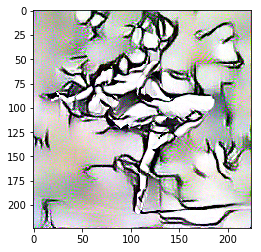

In [230]:
plt.figure()
x = torch.load('./outputs/output_[200].pt')
imshow(x,224)
plt.show()

In [259]:
path_to_style_samples = '/home/jefan/pix2svg/generative/tests/style_test/style_samples/'
all_style_samples = os.listdir('/home/jefan/pix2svg/generative/tests/style_test/style_samples/')
all_style_paths = [os.path.join(path_to_style_samples,i) for i in all_style_samples]
style_subset = [1,3,5,10,20,40]
subset_style_paths = [i for i in all_style_paths if int(i.split('/')[-1].split('.')[0]) in style_subset]

In [261]:
for this_style in subset_style_paths:
    print('Using style sample: ' + this_style)
    ## optimize single image
    n_iters = 200
    style_weight = 300
    content_weight = 1
    save_path = './outputs/output.pt'
    init_lr = 1
    anneal_freq = 100
    cuda_device = 0
    content_img = './images/dancing.jpg'
    style_img = this_style    
    output_dir = this_style.split('/')[-1].split('.')[0]
    save_dir = os.path.join('./outputs',output_dir)

    use_cuda = torch.cuda.is_available()
    dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

    # desired size of the output image
    imsize = 224 if use_cuda else 128  # use small size if no gpu
    
    loader = transforms.Compose([
        transforms.Scale(imsize),  # scale imported image
        transforms.ToTensor()])  # transform it into a torch tensor

    style_img = image_loader(style_img,imsize).type(dtype)
    content_img = image_loader(content_img,imsize).type(dtype)

    assert style_img.size() == content_img.size(), \
        "we need to import style and content images of the same size"

    cnn = models.vgg19(pretrained=True).features

    # move it to the GPU if possible:
    if use_cuda:
        cnn = cnn.cuda(cuda_device)

    # input_img = content_img.clone()
    input_img = Variable(torch.rand(style_img.size())).type(dtype)
    output = run_style_transfer(cnn, content_img, style_img, input_img, use_cuda=use_cuda,
                                num_steps=n_iters, style_weight=style_weight,
                                content_weight=content_weight, init_lr=init_lr,
                                anneal_freq=anneal_freq,save_dir=save_dir)
    torch.save(output, save_path)


Using style sample: /home/jefan/pix2svg/generative/tests/style_test/style_samples/1.png
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1.694324 Content Loss: 0.626693

run [100]:
Style Loss : 1.209785 Content Loss: 0.577685

run [150]:
Style Loss : 1633.388794 Content Loss: 16.689041

run [200]:
Style Loss : 364.723328 Content Loss: 9.423326

Using style sample: /home/jefan/pix2svg/generative/tests/style_test/style_samples/40.png
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 13.476418 Content Loss: 9.618145

run [100]:
Style Loss : 4.820235 Content Loss: 8.934187

run [150]:
Style Loss : 2.642672 Content Loss: 8.194913

run [200]:
Style Loss : 86.832458 Content Loss: 8.475380

Using style sample: /home/jefan/pix2svg/generative/tests/style_test/style_samples/20.png
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 6.820783 Content Loss: 5.732838

run [100]:
Style Loss : 3.163790 Content Loss: 4.854807

run [150]:
S

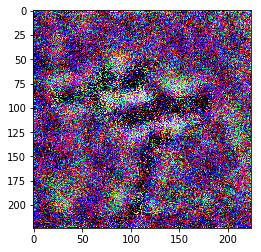

In [262]:
plt.figure()
x = torch.load('./outputs/1/output_[150].pt')
imshow(x,224)
plt.show()

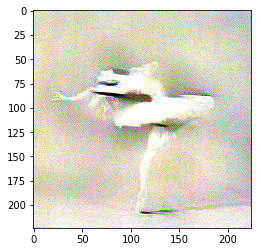

In [263]:
plt.figure()
x = torch.load('./outputs/3/output_[150].pt')
imshow(x,224)
plt.show()

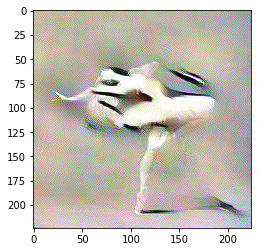

In [264]:
plt.figure()
x = torch.load('./outputs/5/output_[150].pt')
imshow(x,224)
plt.show()

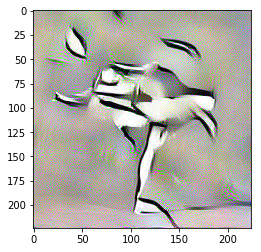

In [265]:
plt.figure()
x = torch.load('./outputs/10/output_[150].pt')
imshow(x,224)
plt.show()

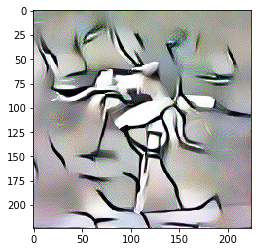

In [266]:
plt.figure()
x = torch.load('./outputs/20/output_[150].pt')
imshow(x,224)
plt.show()

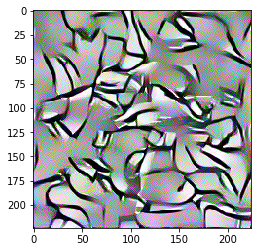

In [267]:
plt.figure()
x = torch.load('./outputs/40/output_[150].pt')
imshow(x,224)
plt.show()

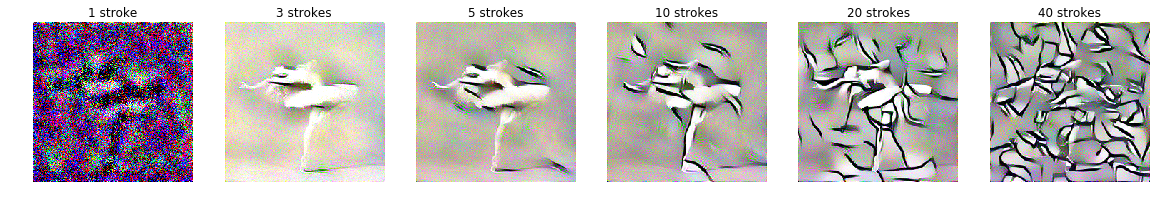

In [278]:
f = plt.figure(figsize=(20,4))
for i,p in enumerate(style_subset):
    plt.subplot(1,6,i+1)
    x = torch.load('./outputs/' + str(p) + '/output_[150].pt')
    plt.axis('off')
    plt.title(str(p) + ' strokes')
    if p==1:
        plt.title(str(p) + ' stroke')
    imshow(x,224)
plt.show()


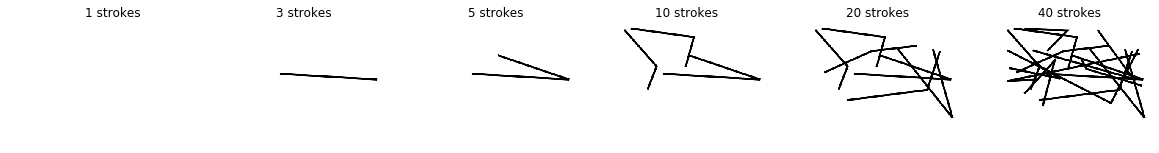

In [292]:
## re-order paths
raw_order = np.asarray([int(i.split('/')[-1].split('.')[0]) for i in subset_style_paths])
inds = np.argsort(raw_order)
_subset_style_paths = np.array(subset_style_paths)
subset_style_paths = _subset_style_paths[inds]

f = plt.figure(figsize=(20,4))
for i,p in enumerate(subset_style_paths):
    plt.subplot(1,6,i+1)
    im = Image.open(p)
    plt.imshow(im)
    plt.axis('off')
    plt.title(str(p.split('/')[-1].split('.')[0]) + ' strokes')
    if p==1:
        plt.title(str(p.split('/')[-1].split('.')[0]) + ' stroke')    
    
plt.show()